In [39]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import yaml
import shap
import src.dax_utils as utils

In [40]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

Load Artifacts

In [41]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

In [42]:
with open('../config/config.yaml', 'r') as file:
    data_loaded = yaml.safe_load(file)

In [43]:
price = pd.read_csv('../db/raw.csv', index_col=0, header=[0,1], parse_dates=[0])
price_data = price.loc[:, pd.IndexSlice[['Open', 'Close'], ['^GDAXI']]]
# price_data.columns = ['gdaxi']
price_data.columns = ['open', 'close']

In [44]:
data_loaded.keys()

dict_keys(['selected_features', 'threshold', 'xgb_classifier_params'])

Train model

In [45]:
model = xgb.XGBClassifier(**data_loaded['xgb_classifier_params'], random_state=42)

In [46]:
model.fit(X_train[data_loaded['selected_features']], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8562910234445663, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0671463942480997,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08180051582631245,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1273, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Simplistic Backtest

<Axes: >

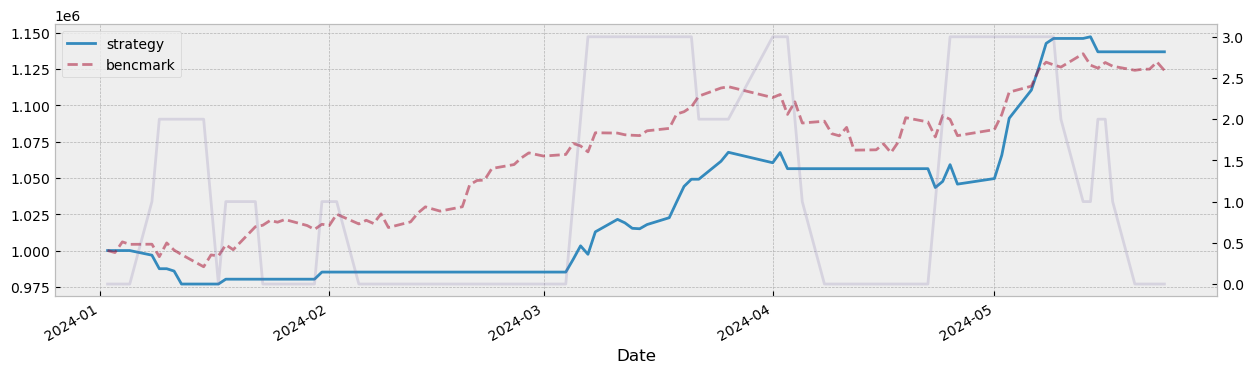

In [49]:
hold_period = 2
inital_cash = 1000000

backtest = pd.concat([price_data['open'].shift(-1), price_data['close'].shift(hold_period*-1)], axis=1).dropna()

signals = model.predict_proba(X_test[data_loaded['selected_features']])[:, 1] > data_loaded['threshold']
signals = pd.DataFrame(signals, index=X_test.index, columns=['signal']).astype(int)

backtest = backtest.join(signals).dropna()
backtest['returns'] = (backtest['close'] / backtest['open']) * backtest['signal']

backtest.loc[backtest.returns == 0, 'returns'] = 1
backtest.iloc[0,3] = inital_cash

backtest.returns.cumprod().plot(figsize=(15, 4), label='strategy', legend=True)
backtest.close.pct_change().add(1).fillna(inital_cash).cumprod().plot(label='bencmark', legend=True, ls='--', alpha=0.5)
pd.concat([backtest.signal.shift(_) for _ in range(0, hold_period+1)], axis=1).fillna(0).sum(axis=1).plot(secondary_y=True, ls='-', alpha=0.2, label='max open position')

Feature importances

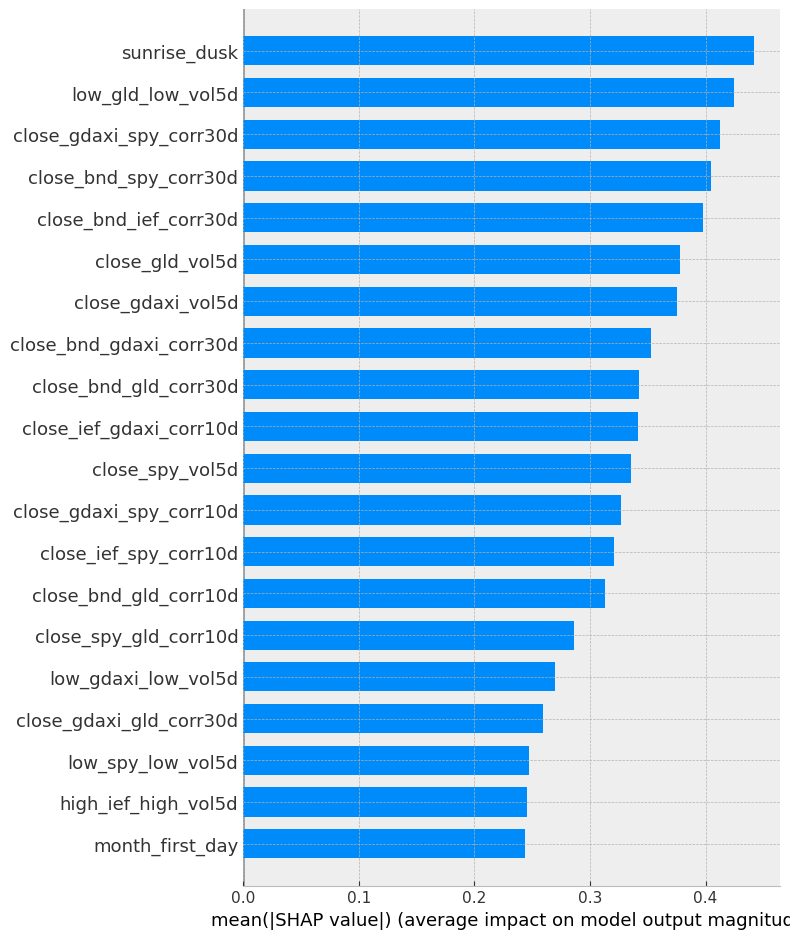

In [10]:
shap_values = shap.TreeExplainer(model).shap_values(X_train[data_loaded['selected_features']])
shap.summary_plot(shap_values, X_train[data_loaded['selected_features']], plot_type="bar")

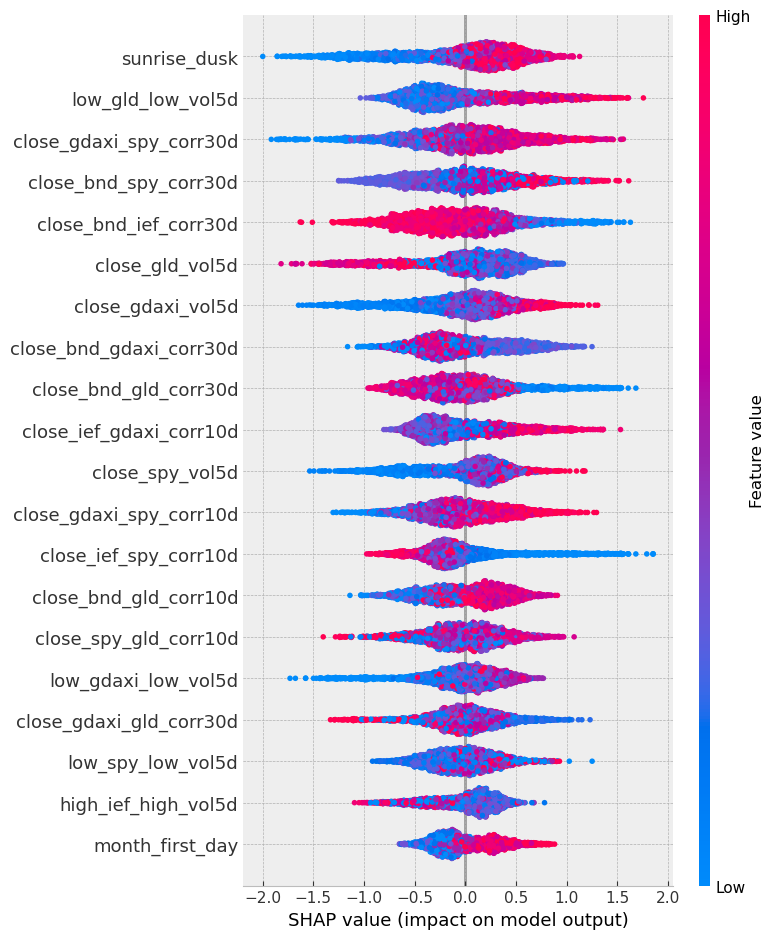

In [11]:
shap.summary_plot(shap_values, X_train[data_loaded['selected_features']])

Quantile analysis

In [12]:
signal_probas = model.predict_proba(X_test[data_loaded['selected_features']])[:, 1] 
signal_probas = pd.DataFrame(signal_probas, index=X_test.index, columns=['signal_probas'])

In [13]:
backtest = backtest.join(signal_probas)
trades = backtest[(backtest.returns != 1) & (backtest.returns != inital_cash)]

In [14]:
trades['probability_bins'] = pd.qcut(trades.signal_probas, 5, labels=range(1,6)).values.to_numpy()

In [15]:
trades.index[1:] - trades.index[:-1]

TimedeltaIndex([ '1 days',  '2 days',  '1 days',  '6 days', '13 days',
                '34 days',  '1 days',  '1 days',  '1 days',  '3 days',
                 '1 days',  '1 days',  '1 days',  '1 days',  '3 days',
                 '1 days',  '1 days',  '1 days',  '4 days',  '1 days',
                 '6 days',  '1 days',  '1 days', '20 days',  '1 days',
                 '1 days',  '1 days',  '5 days',  '1 days',  '1 days',
                 '3 days',  '1 days',  '1 days',  '1 days',  '5 days',
                 '1 days'],
               dtype='timedelta64[ns]', name='Date', freq=None)

In [16]:
from scipy.stats.mstats import hmean

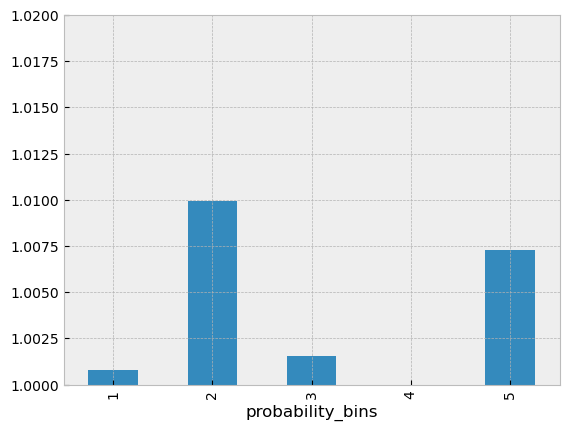

In [17]:
ax = trades.groupby('probability_bins').returns.apply(hmean).plot.bar()
ax.set_ylim(1.0, 1.02) # ax.get_ylim()[1]
plt.show()

Stress test

In [18]:
model = xgb.XGBClassifier(**data_loaded['xgb_classifier_params'])

In [33]:
subset_of_features = [x for x in data_loaded['selected_features'] if not x.startswith('sunrise') ]

In [34]:
model.fit(X_train[subset_of_features], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8562910234445663, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0671463942480997,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08180051582631245,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1273, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [35]:
y_prob = model.predict_proba(X_test[subset_of_features])

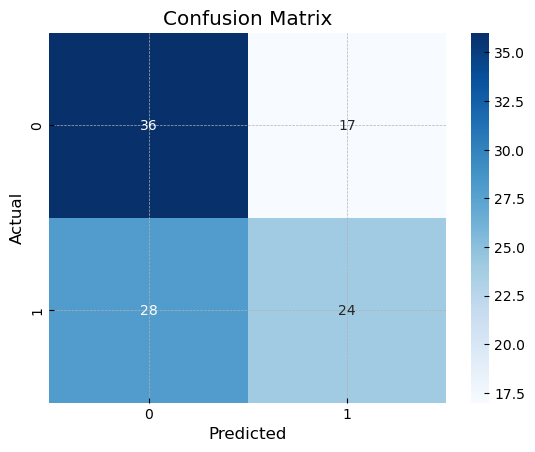

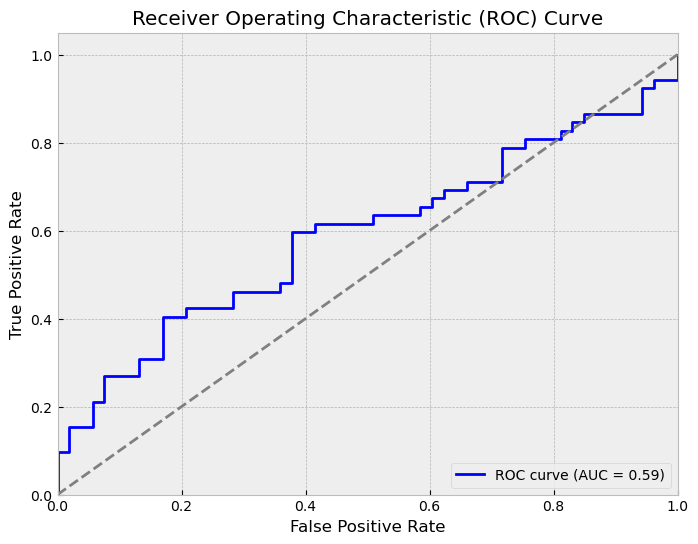

              precision    recall  f1-score   support

           0       0.56      0.68      0.62        53
           1       0.59      0.46      0.52        52

    accuracy                           0.57       105
   macro avg       0.57      0.57      0.57       105
weighted avg       0.57      0.57      0.57       105



In [36]:
utils.Tools.performance_report(y_test, y_prob, [data_loaded['threshold']])

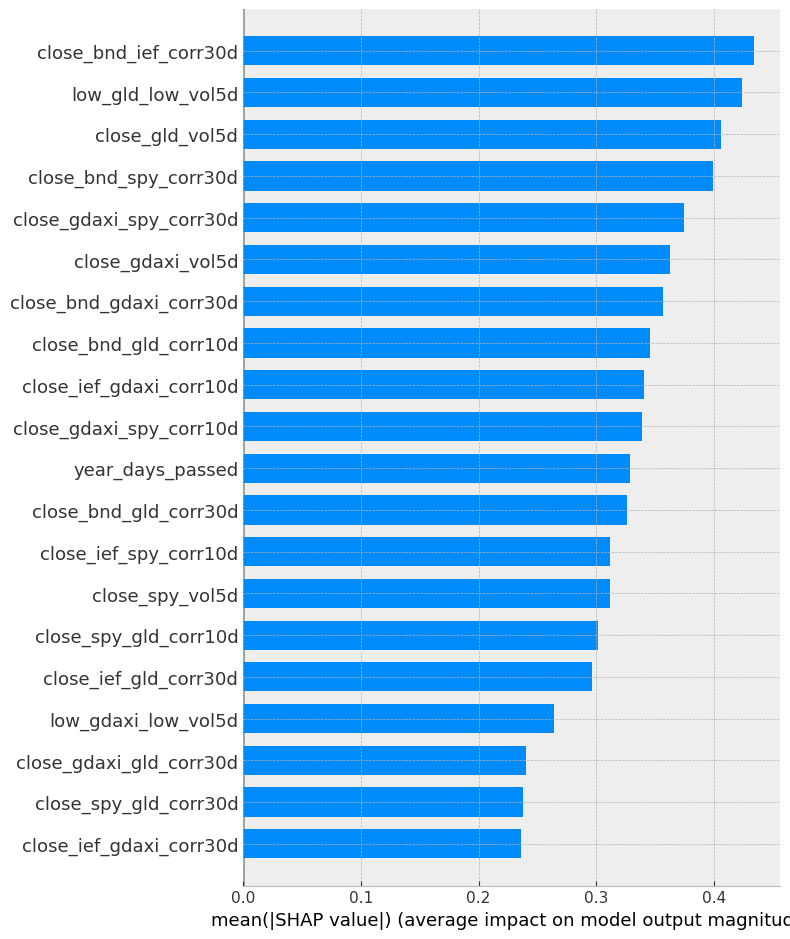

In [37]:
shap_values = shap.TreeExplainer(model).shap_values(X_train[subset_of_features])
shap.summary_plot(shap_values, X_train[subset_of_features], plot_type="bar")